# Detecting Thyroid Cancer Recurrence

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline

import pickle

## Load the data set

In [2]:
df = pd.read_csv("Thyroid-Cancer-Data.csv")

# shape
print(df.shape)
df.head()

(383, 17)


,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


In [3]:
# See the information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    object
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    object
 15  Response              383 non-null    ob

**Comment:**

* There is 383 observations and 17 columns with no missing values. 
* Only one column 'age' is of integer type and others are of object type

In [4]:
# Descriptive stats summary
df.describe()

,Age
count,383.000000
mean,40.866841
std,15.134494
min,15.000000
25%,29.000000
50%,37.000000
75%,51.000000
max,82.000000


**Comment:** 

It seems there is no outlier in age column. Though there is we can handle it with standardization.

#### List out columns based on their data types

In [5]:
# Continuous column
numeric_col = ['Age']

# Nominal columns
nominal_col = ['Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy', 'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology', 'Focality' ]

# Ordinal columns
ordinal_col = ["Risk", "T", "N", "M", "Stage", "Response"]

# Our target column (nominal)
target = "Recurred"

## EDA

In [6]:
df.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


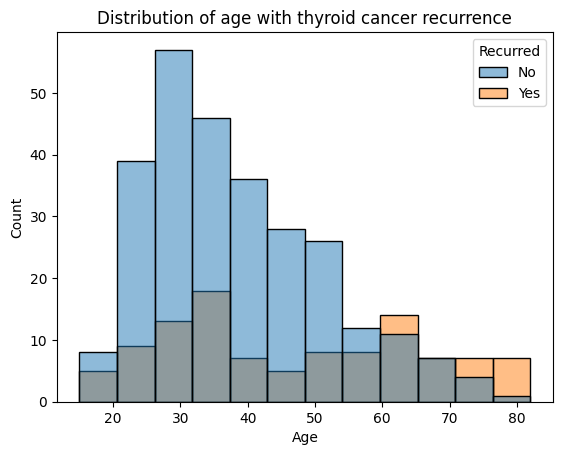

In [7]:
# How age influence the thyroid cancer recurrence
sns.histplot(x='Age', hue='Recurred', data=df)
plt.title("Distribution of age with thyroid cancer recurrence");

**Comment:**

Based on our data set we can say that age near about 35 and near about 63 have the high number of thyroid cancer recurrence. But it seems our data is imbalanced. So, we can not say it exactly.

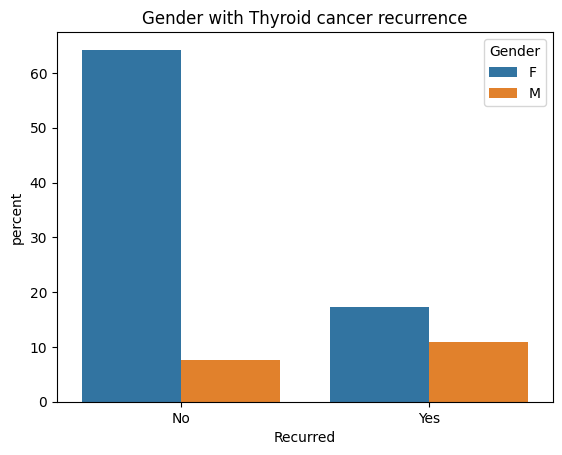

In [8]:
# Gender with thyroid cancer recurrence
sns.countplot(x=target, hue='Gender', data=df, stat='percent')
plt.title('Gender with Thyroid cancer recurrence');

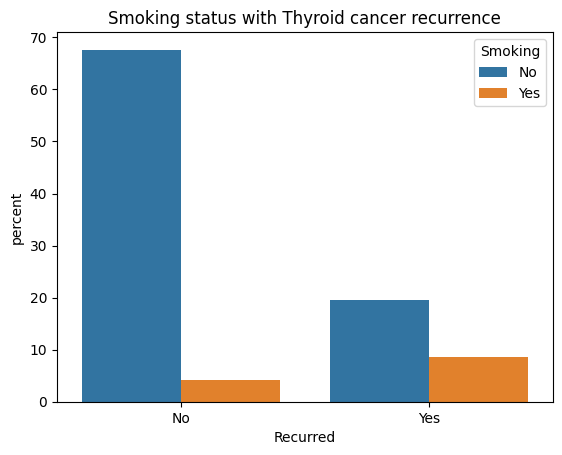

In [9]:
# Smoking status with thyroid cancer recurrence
sns.countplot(x=target, hue='Smoking', data=df, stat='percent')
plt.title('Smoking status with Thyroid cancer recurrence');

**Comment:**

Persons who does smoking has the high chance of thyroid cancer recurrence.

## Encode the target column
Here we use label encoder as target contains ordinal datatype. It is recomended that for target column should use label encoding (also we can use map function to do the same thing manually)

In [10]:
# Instantiate label encoder
le = LabelEncoder()

# Fit and transform the target
df[target] = le.fit_transform(df[target])

# Any random 10 observations
df[target].sample(10)

95     0
346    1
301    1
66     0
51     0
53     0
25     0
103    0
111    0
240    1
Name: Recurred, dtype: int64

#### Check whether data is balanced 

In [11]:
# Percentage of label in target column
(df[target].value_counts()/len(df[target])*100).round()

Recurred
0    72.0
1    28.0
Name: count, dtype: float64

**Comment:**

We are clearly seeing that data is imbalanced. So, we should balance those data but we will do it later after testing the model performance with imbalanced data.

## Data splitting

In [12]:
# Select features and target
features = numeric_col + ordinal_col + nominal_col

# split data into X and y
X = df[features]
y = df[target]

# Shape
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (383, 16)
y shape:  (383,)


In [13]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Shape
print("X_trian_shape: ", X_train.shape)
print("y_trian_shape: ", y_train.shape)
print("X_test_shape: ", X_test.shape)
print("y_test_shape: ", y_test.shape)

X_trian_shape:  (306, 16)
y_trian_shape:  (306,)
X_test_shape:  (77, 16)
y_test_shape:  (77,)


## Model building and Evaluation

### Model Building

In [14]:
# Column transformer
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_col),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'), nominal_col),
    ('ode', OrdinalEncoder(), ordinal_col)
])

# Model pipeline
logis_pipeline = Pipeline([
    ('prepoc', preprocessor),
    ('logis_model', LogisticRegression())
])

# Fit data into the pipeline
logis_pipeline.fit(X_train, y_train)

Pipeline(steps=[('prepoc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Gender', 'Smoking',
                                                   'Hx Smoking',
                                                   'Hx Radiothreapy',
                                                   'Thyroid Function',
                                                   'Physical Examination',
                                                   'Adenopathy', 'Pathology',
                                                   'Focality']),
                                                 ('ode', OrdinalEncoder(),
                                                  ['Risk', 'T', 'N', 'M',
                                                   'Stage', 'Response'])])),
                ('logis_model', LogisticRegression())])

### Evaluation

In [15]:
# Training evaluation
y_train_pred = logis_pipeline.predict(X_train)

# Check accuracy
print(classification_report(y_pred=y_train_pred, y_true=y_train))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       220
           1       0.90      0.84      0.87        86

    accuracy                           0.93       306
   macro avg       0.92      0.90      0.91       306
weighted avg       0.93      0.93      0.93       306



In [16]:
# Testing evaluation
y_test_pred = logis_pipeline.predict(X_test)

# Evaluation report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95        55
           1       0.90      0.86      0.88        22

    accuracy                           0.94        77
   macro avg       0.93      0.91      0.92        77
weighted avg       0.93      0.94      0.93        77



**Comment:**

Model accuracy for logistic regression is good for training and testing also and it shows no overfitting. Let's try with other model.

### Decision Tree model

In [17]:
# Model pipeline
dtc_pipeline = Pipeline([
    ('prepoc', preprocessor),
    ('dt_model', DecisionTreeClassifier(max_depth=8, min_samples_leaf=3,random_state=42))
])

# Fit data into the pipeline
dtc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('prepoc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Gender', 'Smoking',
                                                   'Hx Smoking',
                                                   'Hx Radiothreapy',
                                                   'Thyroid Function',
                                                   'Physical Examination',
                                                   'Adenopathy', 'Pathology',
                                                   'Focality']),
                                                 ('ode', OrdinalEncoder(),
                                                  ['Risk', 'T', 'N', 'M',
                                                   'Stage', 'Response'])])),
                ('dt_model',
                 DecisionTreeClassifier(max_depth=8, min_samples_leaf=3,
                                        random_state=42))])

In [18]:
# Training evaluation
y_train_pred = dtc_pipeline.predict(X_train)

# Check accuracy
print(classification_report(y_pred=y_train_pred, y_true=y_train))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       220
           1       0.95      0.94      0.95        86

    accuracy                           0.97       306
   macro avg       0.97      0.96      0.96       306
weighted avg       0.97      0.97      0.97       306



In [19]:
# Testing evaluation
y_test_pred = dtc_pipeline.predict(X_test)

# Evaluation report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        55
           1       1.00      0.91      0.95        22

    accuracy                           0.97        77
   macro avg       0.98      0.95      0.97        77
weighted avg       0.97      0.97      0.97        77



**Comment:**

It is also doing better than logistic regression model. Let's try with random forest classifier.

### Random Forest Classifier

In [20]:
# Model pipeline
rfc_pipeline = Pipeline([
    ('prepoc', preprocessor),
    ('rfc_model', RandomForestClassifier(n_estimators=200,max_depth=9, min_samples_leaf=4,random_state=42))
])

# Fit data into the pipeline
rfc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('prepoc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Gender', 'Smoking',
                                                   'Hx Smoking',
                                                   'Hx Radiothreapy',
                                                   'Thyroid Function',
                                                   'Physical Examination',
                                                   'Adenopathy', 'Pathology',
                                                   'Focality']),
                                                 ('ode', OrdinalEncoder(),
                                                  ['Risk', 'T', 'N', 'M',
                                                   'Stage', 'Response'])])),
                ('rfc_model',
                 RandomForestClassifier(max_depth=9, min_samples_leaf=4,
                                        n_estimators=200, random_state=42))])

In [21]:
# Training evaluation
y_train_pred = rfc_pipeline.predict(X_train)

# Check accuracy
print(classification_report(y_pred=y_train_pred, y_true=y_train))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       220
           1       0.97      0.90      0.93        86

    accuracy                           0.96       306
   macro avg       0.97      0.94      0.95       306
weighted avg       0.96      0.96      0.96       306



In [22]:
# Testing evaluation
y_test_pred = rfc_pipeline.predict(X_test)

# Evaluation report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        55
           1       1.00      0.91      0.95        22

    accuracy                           0.97        77
   macro avg       0.98      0.95      0.97        77
weighted avg       0.97      0.97      0.97        77



**Comment:** 

Model is perfoming great though recall is low. Let's try with balance data set.

## Balance the dataset

In [23]:
# Column indices for SMOTENC (categorical before encoding)
cat_indices = [X_train.columns.get_loc(col) for col in nominal_col + ordinal_col]

# SMOTENC for raw categorical columns
smote = SMOTENC(categorical_features=cat_indices, random_state=42)

# Full pipeline
pipeline = ImbPipeline(steps=[
    ('sampling', smote),
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=150,max_depth=10, min_samples_leaf=3,random_state=42))
])

# Fit pipeline
pipeline.fit(X_train, y_train)

e:\Learning\Coding\AI\02 - Machine Learning\Machine-Learning-Projects\ml_venv\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
e:\Learning\Coding\AI\02 - Machine Learning\Machine-Learning-Projects\ml_venv\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
e:\Learning\Coding\AI\02 - Machine Learning\Machine-Learning-Projects\ml_venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTENC or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, 

Pipeline(steps=[('sampling',
                 SMOTENC(categorical_features=[7, 8, 9, 10, 11, 12, 13, 14, 15,
                                               1, 2, 3, 4, 5, 6],
                         random_state=42)),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Gender', 'Smoking',
                                                   'Hx Smoking',
                                                   'Hx Radiothreapy',
                                                   'Thyroid Function',
                                                   'Physical Examination',
                                                   'Adenopathy', 'Pathology',
                                                   'Focality']),
                                                 ('ode', OrdinalEncoder(),
                                                  ['Risk', 'T', 'N', 'M',
                                                   'Stage', 'Response'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=3,
                                        n_estimators=150, random_state=42))])

In [24]:
# Training evaluation
y_train_pred = pipeline.predict(X_train)

# Check accuracy
print(classification_report(y_pred=y_train_pred, y_true=y_train))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       220
           1       0.98      0.94      0.96        86

    accuracy                           0.98       306
   macro avg       0.98      0.97      0.97       306
weighted avg       0.98      0.98      0.98       306



In [25]:
# Testing evaluation
y_test_pred = pipeline.predict(X_test)

# Evaluation report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        55
           1       1.00      0.91      0.95        22

    accuracy                           0.97        77
   macro avg       0.98      0.95      0.97        77
weighted avg       0.97      0.97      0.97        77



**Comment:**

* This is overall a good result

**After balancing** the data there are some changes noticable:

* Training recall for the minority class jumped from 0.90→0.94, so you’re catching more positives after balancing.
* Precision and F1 also improved slightly on the train set.
* Test metrics stayed essentially the same, indicating no over‑fitting.

<br/>

**Note:**

As pipeline after data balancing performs better, we are taking it as our final model.

In [26]:
# Final model
final_model = pipeline

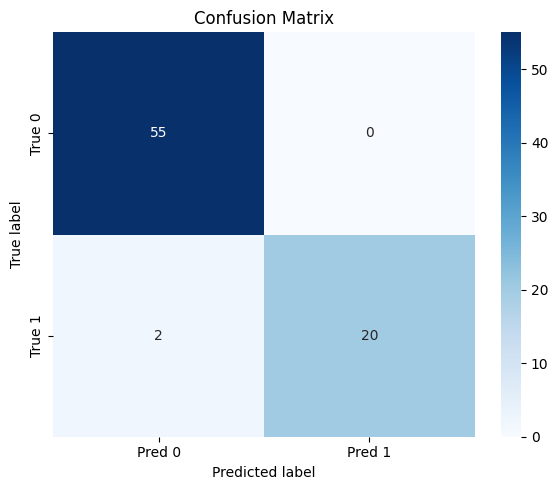

In [27]:
## Display the confusion matrix
# Predictions
y_pred = final_model.predict(X_test) 

# confusion matrix 
cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,       
    fmt='d',          
    cmap='Blues',
    xticklabels=['Pred 0','Pred 1'],
    yticklabels=['True 0','True 1']
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

Test ROC‐AUC = 0.990


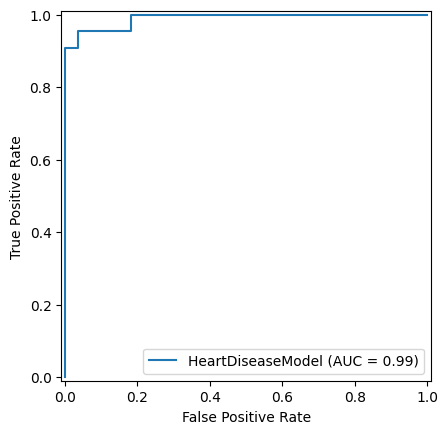

In [28]:
# Get the probability estimates for the “disease” class (label=1)
y_proba = final_model.predict_proba(X_test)[:, 1]

#  Compute ROC‐AUC
auc = roc_auc_score(y_test, y_proba)
print(f"Test ROC‐AUC = {auc:.3f}")

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc,
                       estimator_name="HeartDiseaseModel")
disp.plot()
plt.show()

## Save and use the model

In [29]:
# Save the model
with open('model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

In [30]:
# Load the model
with open('model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

#### Prediction with loaded model

In [31]:
# Test prediction
y_pred = loaded_model.predict(X_test)

# Make a dataframe with actual and predicted values
df_pred = pd.DataFrame(data={'y_actual': y_test, 'y_predicted': y_pred})

# Prediction data frame with tagged
df_pred['pred_label'] = df_pred['y_predicted'].map({0: 'cancer does not recurred', 1: 'cancer recurred'})


# Add predicion status to the pred_df
df_pred['status'] = (df_pred["y_actual"]==df_pred["y_predicted"]).apply(lambda obs: 'Correct prediction' if obs==True else "Wrong prediction" )

# See any random 10 prediction
df_pred.sample(10)

,y_actual,y_predicted,pred_label,status
356,1,1,cancer recurred,Correct prediction
363,1,1,cancer recurred,Correct prediction
51,0,0,cancer does not recurred,Correct prediction
180,0,0,cancer does not recurred,Correct prediction
296,0,0,cancer does not recurred,Correct prediction
278,0,0,cancer does not recurred,Correct prediction
241,1,1,cancer recurred,Correct prediction
306,1,1,cancer recurred,Correct prediction
230,1,1,cancer recurred,Correct prediction
280,0,0,cancer does not recurred,Correct prediction
